<a href="https://colab.research.google.com/github/olexandr7/erm_workshop/blob/main/ERM_workshop_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Workshop 1** is focused on trying out textual and a bit of graphical manipulations

Let's now pick a museum collection from MuIS and try several operations:
* loading all items from collection
* making a word cloud out of item titles
* making a word cloud for a specific item - in item's shape
* exporting collection to Excel

In [30]:
#running first script in Python
print('Hello World! | Tere Maailm!')

Hello World! | Tere Maailm!


**Block 1**: installing relevant libraries for textual and graphic manipulations

In [1]:
#RDF scripts are taken from rdflib tutorial:
#https://rdflib.readthedocs.io/en/stable/gettingstarted.html#a-more-extensive-example
#-------------------------------
#RDF manipulations
%pip install rdflib
#-------------------------------
#plotting
import matplotlib.pyplot as plt
#manipulations with dataframes
import pandas as pd
#URL requests loading
import urllib.request
#multidimensional arrays
import numpy as np
#image manipulation
import cv2
#---------------------------
#workaround to show opencv images in Colab
from google.colab.patches import cv2_imshow
#RDF manipulations - graphics
from rdflib import Graph
#visualizing word cloud
from wordcloud import WordCloud
#downloading files from Colab
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.7 MB/s eta 0:00:00


**Block 2**: Displaying details of MuIS item in RDF
<br>  <font color='orange'>CHANGE:</font> Try changing URL to any other item from MUiS - there's a *püsiviide/permalink* for each item in the interface
https://www.muis.ee/museaalview/1887998 -> https://opendata.muis.ee/object/1887998

In [17]:
# Create a Graph
g = Graph()
#this item could be viewed from MuIS UI via: https://www.muis.ee/museaalview/3761070
# Parse in an RDF file hosted on the Internet
g.parse("https://opendata.muis.ee/object/1537361")         #<---CHANGE: URL could be changed to any item from MuIS
#displaying RDF contents - details about specific item
for s, p, o in g:
    print(s, '|', p, '|', o)

Ndd74677461be400583e45d0969a00b7d | http://www.w3.org/1999/02/22-rdf-syntax-ns#type | http://www.w3.org/2002/07/owl#Ontology
Nd6670251aa484e4e9149ae0662500f3a | http://www.cidoc-crm.org/cidoc-crm/P43_has_dimension | N6731c3c7a5724ad18fd4aa154c062526
http://opendata.muis.ee/object/1537361 | http://opendata.muis.ee/rdf-schema/muis.rdfs#acr | AM
http://opendata.muis.ee/object/1537361 | http://opendata.muis.ee/rdf-schema/muis.rdfs#kt | E
Nbad6eccfe4ca41c08d55fc0f3c84c85a | http://www.w3.org/1999/02/22-rdf-syntax-ns#type | http://www.cidoc-crm.org/cidoc-crm/E3_Condition_State
N28aca279c3f84a03bd3b3dfd162583ba | http://www.w3.org/1999/02/22-rdf-syntax-ns#type | http://opendata.muis.ee/rdf-schema/muis.rdfs#Color
N061f134ae994417ca355be614dff12a4 | http://www.cidoc-crm.org/cidoc-crm/P2_has_type | http://opendata.muis.ee/thesaurus/49/2485
Ndd74677461be400583e45d0969a00b7d | http://purl.org/dc/terms/created | Thu Aug 15 16:16:13 EEST 2024
http://opendata.muis.ee/object/1537361 | http://www.cidoc

🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛
<br>
**Dataset**: bricks collection (Muuseumikogu: tellised) from Tallinna Linnamuuseum
<br>
https://www.muis.ee/catalogue:kogu/93619-849
<br>
🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛🏛

**Block 3**: Loading all items from collection into a list
<br>  <font color='orange'>CHANGE:</font> Try changing URL to a different MuIS collection

In [15]:
g = Graph()
g1 = Graph()
collectionitemslist = []

# Parse in an RDF file
g.parse("http://www.muis.ee/rdf/collection/849")    #<---CHANGE: could be changed to any collection from MuIS
g1.parse("http://www.muis.ee/rdf/collection/837")    #<---CHANGE: could be changed to any collection from MuIS
#----------------------------------------------------------
#http://www.muis.ee/rdf/collection/837  #Tallinn city museum - textile collection/tekstiil
#http://www.muis.ee/rdf/collection/849  #Tallinn city museum - bricks collection/tellised
#http://www.muis.ee/rdf/collection/1288 #ERM - collection of postcards/postkaardikogu
#-----------------------------------------------------------

#loop through RDF triples
for s, p, o in g:
    if "P46_is_composed_of" in p: collectionitemslist.append(o)

for s, p, o in g1:
    if "P46_is_composed_of" in p: collectionitemslist.append(o)

#counting items within the list
count = 0
for items in collectionitemslist:
        count = count + 1
print("Total count of items in collection:", count)

Total count of items in collection: 4153


**Block 4**: Loading details for each of the items into a dataframe
<br>
At the moment we're specifically interested in 2 fields:
*  item's URL
*  item's title (nimetus)

Since the collection size could be quite extensive, we're going to load only 50 items (in random order)

<font color='orange'>CHANGE: </font> Try changing the count of items and get more data

In [4]:
#Generating dataset for wordcloud

#filtering out values from valid URLs, adding them into two lists
collectionitemslist_url = []
collectionitemslist_title = []

iter = 0

for i in collectionitemslist:
    g = Graph()
    try:
      g.parse(i)
      for s, p, o in g:
            if "http://opendata.muis.ee/object/" in s and "www.w3.org/2000/01/rdf-schema#label" in p:  print(iter, ':', o),  collectionitemslist_url.append(i), collectionitemslist_title.append(o)
      iter += 1
      if iter == 50:           #<---CHANGE: number of items could be adjusted
        break
    except Exception:
        pass
#making dataframe out of 2 lists
df = pd.DataFrame(list(zip(collectionitemslist_url, collectionitemslist_title)))
df = df.rename(columns={0: 'URL', 1: 'Title'})

#displaying dataframe
df

0 : Tellis
1 : Katusekivi nn nunnkivi
2 : Katusekivi, fragment
3 : Tellis
4 : Katusekivi nn munkkivi
5 : Tellis
6 : Katusekivi nn munkkivi
7 : Tellis
8 : Tellis
9 : Katusekivi nn munkkivi
10 : Katusekivi nn nunnkivi
11 : Tellis, poolik
12 : Katusekivi, harjakivi
13 : Katusekivi nn nunnkivi
14 : Tellis
15 : Tellis
16 : Tellis
17 : Katusekivi nn munkkivi
18 : Tellis
19 : Tellis
20 : Katusekivi, harjakivi
21 : Katusekivi
22 : Tellis
23 : Fassaadi tellis
24 : Tellis
25 : Vahtsilikatsiit vaheplaat-tellis
26 : Tellis
27 : Silikaattellis
28 : Tuhkliivkivi tellis
29 : Tellis
30 : Tellis
31 : Katusekivi nn nunnkivi
32 : Katusekivi, nn nunnkivi fragment
33 : Tellis
34 : Tellis
35 : Katusekivi nn nunnkivi
36 : Kärgtellis
37 : Katusekivi nn munkkivi
38 : Kärgtellis
39 : Tellis
40 : Katusekivi, harjakivi
41 : Tellis
42 : Tellis
43 : Katusekivi nn nunnkivi fragment
44 : Tellis
45 : Tellis
46 : Katusekivi nn munkkivi
47 : Katusekivi
48 : Tellis
49 : Katusekivi nn nunnkivi


,URL,Title
0,http://opendata.muis.ee/object/1199628,Tellis
1,http://opendata.muis.ee/object/1192446,Katusekivi nn nunnkivi
2,http://opendata.muis.ee/object/1203128,"Katusekivi, fragment"
3,http://opendata.muis.ee/object/1192433,Tellis
4,http://opendata.muis.ee/object/1198735,Katusekivi nn munkkivi
5,http://opendata.muis.ee/object/1200852,Tellis
6,http://opendata.muis.ee/object/1192393,Katusekivi nn munkkivi
7,http://opendata.muis.ee/object/1192447,Tellis
8,http://opendata.muis.ee/object/1199351,Tellis
9,http://opendata.muis.ee/object/1192399,Katusekivi nn munkkivi


No charts were generated by quickchart


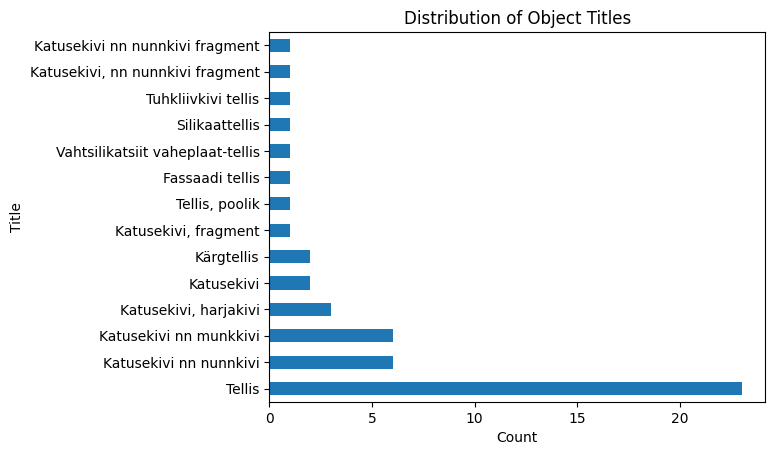

In [5]:
# @title Distribution of Object Titles

import matplotlib.pyplot as plt

df['Title'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Title')
_ = plt.title('Distribution of Object Titles')

🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖
<br>
Let's try using Colab functionality (auto-suggestions or built-in AI) and *generate frequency chart* automatically
<br>🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖

**Block 4**: Making word cloud out of loaded collection data (item titles)
<br>  <font color='orange'>CHANGE: </font> Try modifying the background color and observe how wordcloud changes

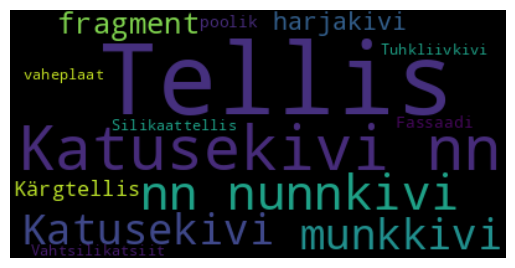

In [6]:
#Creating wordcloud based on example from:
#https://github.com/amueller/word_cloud/blob/main/examples/simple.py

#creating a single string with all values from title column
df_joined = ' '.join(df['Title'].to_list())

#creating wordcloud
wordcloud = WordCloud(max_font_size=80, background_color="black", contour_color='steelblue') #<---CHANGE: background color could be modified
#generating word cloud from data (single string with all values)
wordcloud.generate(df_joined)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#displaying word cloud
plt.show()

**Block 5**: Making advanced word cloud - displaying individual item's label inside item's visual outline.

So as an example, we could have outline of a hat and then display contents of a label field inside that outline

In [7]:
#loading data for specific item
g = Graph()
tinycollectionitemslist_label = []

#parsing sled blanket: https://www.muis.ee/museaalview/1537361
g.parse("https://opendata.muis.ee/object/1537361")
for s, p, o in g:
  if "http://opendata.muis.ee/object/" not in s and "rdf-schema#label" in p and "tervik" not in o: tinycollectionitemslist_label.append(o)

#making dataframe out of a list
df_tiny = pd.DataFrame(list(zip(tinycollectionitemslist_label)))
df_tiny = df_tiny.rename(columns={0: 'Label'})
#creating a single string with all values from label  column
df_joined_tiny = ' '.join(df_tiny['Label'].to_list())
#displaying label text
df_joined_tiny

'Tikitud saanitekk, hallist kodukootud villasest riidest. Vaiba ühte äärde tikitud villaste lõngadega mitmevärviline tikand, mis koosneb punakais toonides õitest ja ruudukestest kollakais-rohekais toonides lehtedest ja joontest. Servad masinpalistusega.'

**Block 6**: Manupulating with masking image (outline) - so that it would be optimal for wordcloud

Simple geometric shapes work best - as it's easy to fit words inside

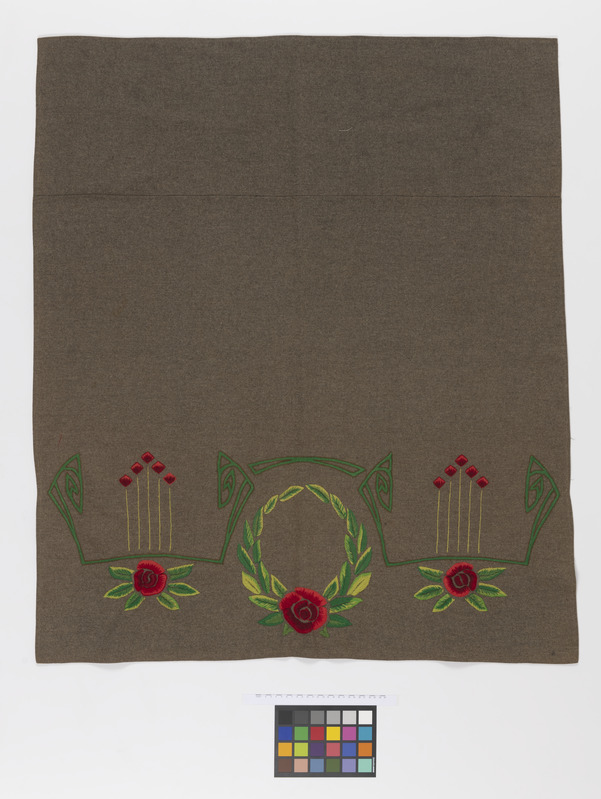

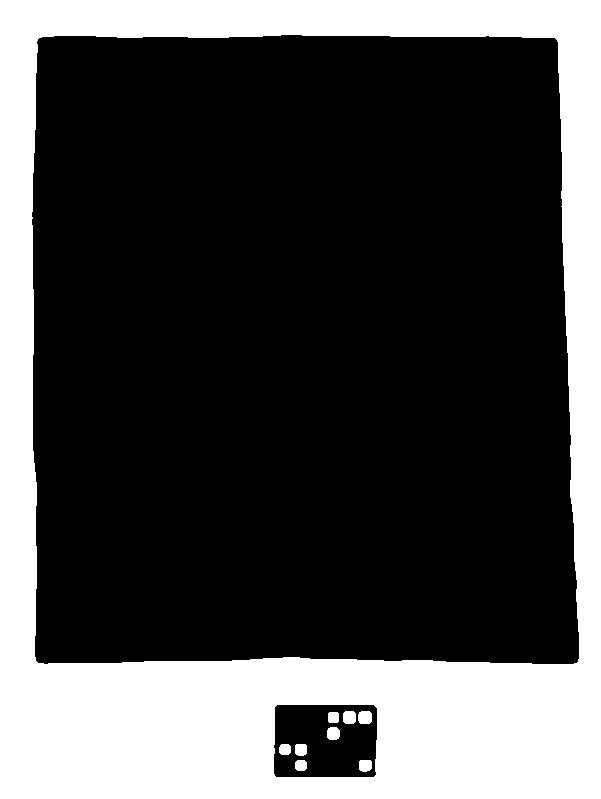

In [8]:
#https://www.muis.ee/museaalview/402105

# read the mask image
url = "https://www.muis.ee/digitaalhoidla/api/meedia/pisipilt?id=650d7c6d-a6e5-47c6-8c8a-3531bdd5f54c"  #<---CHANGE:  URL could be changed to any image from MuIS
url_response = urllib.request.urlopen(url)
mask_image = cv2.imdecode(np.array(bytearray(url_response.read()), dtype=np.uint8), -1)

#converting image to greyscale
mask_image_grey = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)


#adaptive thresholding
mask_image_grey = cv2.medianBlur(mask_image_grey,5)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(mask_image_grey,(5,5),0)
ret3,mask_image_binarized = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#displaying images
cv2_imshow(mask_image)
cv2_imshow(mask_image_binarized)

**Block 7**: Manupulating masking image and displaying wordcloud
<br>  <font color='orange'>CHANGE: </font> Try changing the content - display custom text in the wordcloud

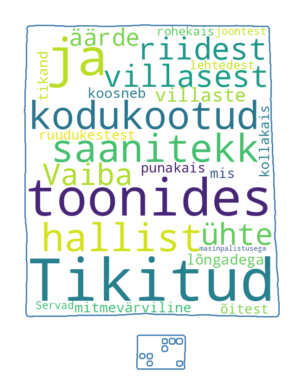

In [9]:
#example taken from:
#https://github.com/amueller/word_cloud/blob/main/examples/masked.py
#https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

wc = WordCloud(background_color="white", max_words=1000, max_font_size=400, mask=mask_image_binarized,
              contour_width=3, contour_color='steelblue')

#df_joined_tiny = 'Lorem ipsum dolor sit amet lorem ipsum ipsum ipsum ipsum'  #<---CHANGE:  uncomment to have custom text displayed in wordcloud

# generate word cloud
wc.generate(df_joined_tiny)

# show
plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓
<br>Let's now look into exporting MuIS content into Excel file
<BR>
📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓

**Block 8**: Loading item details into a dataframe - choosing column that we would like to see in output (excel) file
<br>  <font color='orange'>CHANGE: </font> Try changing the count of items that would be loaded

In [10]:
collectionitemslist

[rdflib.term.URIRef('http://opendata.muis.ee/object/1199628'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1192446'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1203128'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1192433'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1198735'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1200852'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1192393'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1192447'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1199351'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1192399'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1204063'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1197572'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1201362'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1201367'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/1199629'),
 rdflib.term.URIRef('http://opendata.muis.ee/object/120

In [18]:
#filtering out values from valid URLs, adding them into multiple lists
collectionitemslist_url1 = []
collectionitemslist_url2 = []
collectionitemslist_url3 = []
collectionitemslist_url4 = []
collectionitemslist_url5 = []
collectionitemslist_url6 = []
collectionitemslist_url7 = []
#----------------------------
collectionitemslist_title = []
collectionitemslist_label = []
collectionitemslist_availabiletime = []
collectionitemslist_identifier = []
collectionitemslist_publisher = []
collectionitemslist_collection = []
collectionitemslist_image = []


iter = 0

for i in collectionitemslist:
    g = Graph()
    try:
        print(i)
        g.parse(i)
        for s, p, o in g:
            if "http://opendata.muis.ee/object/" in s and "www.w3.org/2000/01/rdf-schema#label" in p:  print(iter, ':', 'title |', o), collectionitemslist_url1.append(i), collectionitemslist_title.append(o)
            if "purl.org/dc/terms/available" in p:  print(iter, ':', 'availabile_time |', o), collectionitemslist_url2.append(i), collectionitemslist_availabiletime.append(o)
            if "purl.org/dc/terms/identifier" in p:  print(iter, ':', 'identifier |', o), collectionitemslist_url3.append(i), collectionitemslist_identifier.append(o)
            if "purl.org/dc/elements/1.1/publisher" in p:  print(iter, ':', 'publisher |', o), collectionitemslist_url4.append(i), collectionitemslist_publisher.append(o)
            if "http://opendata.muis.ee/object/" in s and "cidoc-crm/P46i_forms_part_of" in p and "/collection/" in o:  print(iter, ':', 'collection |', o), collectionitemslist_url5.append(i), collectionitemslist_collection.append(o)
            if "http://opendata.muis.ee/object/" not in s and "rdf-schema#label" in p and "tervik" not in o:  print(iter, ':', 'label |', o), collectionitemslist_url6.append(i), collectionitemslist_label.append(o)
            if "http://xmlns.com/foaf/0.1/depiction" in p:  print(iter, ':', 'image_links |', o), collectionitemslist_url7.append(i), collectionitemslist_image.append(o)
        print('----------------------------------------')
        iter += 1
        if iter == 20:           #<---CHANGE: number of items to load could be adjusted
          break
    except:
        pass

http://opendata.muis.ee/object/1199628
0 : availabile_time | 15-05-1966
0 : publisher | Estonian Ministry of Culture
0 : image_links | http://opendata.muis.ee/media-list/1199628
0 : title | Tellis
0 : label |   22 / HÖGANA /C.  
0 : label | Kollasest savist vormitud ja põletatud. Kivi keskele pressitud märk.
0 : identifier | TLM _ 10610:10 TE 43
0 : collection | http://www.muis.ee/rdf/collection/849
----------------------------------------
http://opendata.muis.ee/object/1192446
1 : availabile_time | 23-07-1958
1 : title | Katusekivi nn nunnkivi
1 : image_links | http://opendata.muis.ee/media-list/1192446
1 : collection | http://www.muis.ee/rdf/collection/849
1 : identifier | TLM _ 8377 TE 22
1 : publisher | Estonian Ministry of Culture
1 : label | Alumine ehk nn nunnkivi põletatud punasest savist, piklik, kumer pealispind. Ülemise otsa välisküljel kolmnurkne eend ja külgedel kandilised avad.
----------------------------------------
http://opendata.muis.ee/object/1203128
2 : identifier 

**Block 9**: Doing manipulations on loaded data
<br>
Idea is that we load each column into individual dataframe and afterwards combine them on common key (URL is this case).

In [19]:
#special logic for Labels - as one item could have multiple lables so we need to combine them in one column
df_labels = pd.DataFrame(list(zip(collectionitemslist_url6, collectionitemslist_label)))
df_labels = df_labels.rename(columns={0: 'URL',1: 'Label'})
#concatenating labels
df_labels = df_labels.groupby('URL')['Label'].apply(' '.join).reset_index()
#--------------------------------------------------------------------------
#creating dataframes for other columns
df_collection = pd.DataFrame(list(zip(collectionitemslist_url5, collectionitemslist_collection)))
df_publisher = pd.DataFrame(list(zip(collectionitemslist_url4, collectionitemslist_publisher)))
df_identifier = pd.DataFrame(list(zip(collectionitemslist_url3, collectionitemslist_identifier)))
df_availabletime = pd.DataFrame(list(zip(collectionitemslist_url2, collectionitemslist_availabiletime)))
df_title = pd.DataFrame(list(zip(collectionitemslist_url1, collectionitemslist_title)))
df_image = pd.DataFrame(list(zip(collectionitemslist_url7, collectionitemslist_image)))
#--------------------------------------------------------------------------
#renaming columns
df_collection = df_collection.rename(columns={0: 'URL',1: 'Collection'})
df_publisher = df_publisher.rename(columns={0: 'URL',1: 'Publisher'})
df_identifier = df_identifier.rename(columns={0: 'URL',1: 'Identifier'})
df_availabletime = df_availabletime.rename(columns={0: 'URL',1: 'Available_time'})
df_title = df_title.rename(columns={0: 'URL',1: 'Title'})
df_image = df_image.rename(columns={0: 'URL',1: 'Image'})
#finally merging all dataframes together on URL column
df_labels.set_index('URL',inplace=True)
df_collection.set_index('URL',inplace=True)
df_publisher.set_index('URL',inplace=True)
df_identifier.set_index('URL',inplace=True)
df_availabletime.set_index('URL',inplace=True)
df_title.set_index('URL',inplace=True)
df_image.set_index('URL',inplace=True)
df_all = pd.concat([df_identifier, df_title, df_availabletime, df_publisher, df_collection, df_image, df_labels],axis=1,sort=False).reset_index()
#displaying dataframe
df_all

,URL,Identifier,Title,Available_time,Publisher,Collection,Image,Label
0,http://opendata.muis.ee/object/1199628,TLM _ 10610:10 TE 43,Tellis,15-05-1966,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849,http://opendata.muis.ee/media-list/1199628,22 / HÖGANA /C. Kollasest savist vormitud ...
1,http://opendata.muis.ee/object/1192446,TLM _ 8377 TE 22,Katusekivi nn nunnkivi,23-07-1958,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849,http://opendata.muis.ee/media-list/1192446,Alumine ehk nn nunnkivi põletatud punasest sav...
2,http://opendata.muis.ee/object/1203128,TLM _ 26717 TE 72,"Katusekivi, fragment",07-04-2003,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849,http://opendata.muis.ee/media-list/1203128,"Nn. nunnkivi, punasest savist, poolümar. Otsal..."
3,http://opendata.muis.ee/object/1192433,TLM _ 8024:7 TE 17,Tellis,23-07-1958,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849,http://opendata.muis.ee/media-list/1192433,"Mõigasroide tellis, punasest põletatud savist."
4,http://opendata.muis.ee/object/1198735,TLM _ 15104:11 TE 58,Katusekivi nn munkkivi,15-09-1976,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849,http://opendata.muis.ee/media-list/1198735,"Nn. munkkivi, punasest savist, poolümar. Kivi ..."
5,http://opendata.muis.ee/object/1200852,TLM _ 10610:9 TE 42,Tellis,15-05-1966,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849,http://opendata.muis.ee/media-list/1200852,Rist või neljalehelise ristikheina leht. Punas...
6,http://opendata.muis.ee/object/1192393,TLM _ 8376 TE 21,Katusekivi nn munkkivi,23-07-1958,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849,http://opendata.muis.ee/media-list/1192393,Ülemine ehk nn munkkivi põletatud punasest sav...
7,http://opendata.muis.ee/object/1192447,TLM _ 8024:4 TE 14,Tellis,23-07-1958,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849,http://opendata.muis.ee/media-list/1192447,"Mõigasroide tellis, punasest põletatud savist."
8,http://opendata.muis.ee/object/1199351,TLM _ 4551:1 TE 3,Tellis,19-11-1957,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849,http://opendata.muis.ee/media-list/1199351,Saadud Pirita kloostri Püha Birgitta kabelist ...
9,http://opendata.muis.ee/object/1192399,TLM _ 8375 TE 20,Katusekivi nn munkkivi,23-07-1958,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849,http://opendata.muis.ee/media-list/1192399,Ülemine ehk nn munkkivi põletatud punasest sav...


**Block 10**: Exporting dataframe to excel file
<br>  <font color='orange'>CHANGE: </font> Try changing the excel file name


In [20]:
#file export out
df_all.to_excel("excel_extract.xlsx")          #<---CHANGE: file name could be changed
#downloading file from browser
files.download('excel_extract.xlsx')       #<---CHANGE: file name could be changed

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This would be it, thank you!
<br>
🔚🔚🔚🔚🔚🔚🔚🔚🔚🔚🔚🔚🔚🔚🔚